# PLEX: Perturbation-free Local Explanations for LLM-Based Text Classification
## Load neccesary functions

In [45]:
import torch
print(torch.cuda.is_available())  # Should return True if the GPU is accessible
import lime
import lime.lime_text
import shap
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification
import pandas as pd
import torch.nn as nn
import transformers
import torch.optim as optim
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import random
import pickle
import warnings

import time

warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")


# Seismic network with regularization
class SeismicNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with p=0.5

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first layer
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


# Instantiate the seismic network
input_size = 768  # Get the appropriate input size
seismic_net = SeismicNet(input_size)
seismic_net.to(device)

True
GPU is available and being used


SeismicNet(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [57]:
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=-1)
    return probabilities.detach().cpu().numpy()

 
def word_emb(text):
    inputs = tokenizer(text, return_tensors="pt", return_offsets_mapping=True).to(device)
    offset_mapping = inputs['offset_mapping']
    outputs = model(**{k: v for k, v in inputs.items() if k in ['input_ids', 'attention_mask']})

    # Extract CLS embedding and word embeddings from the last layer
    cls_embedding = outputs.hidden_states[-1][:, 0, :].squeeze().detach().cpu()
    word_embeddings = {}  # Use a dictionary to store word-embedding pairs
    for i, (start, end) in enumerate(inputs['offset_mapping'][0]):
        if i == 0 or i == len(inputs['offset_mapping'][0]) - 1:  # Skip CLS and SEP
            continue
        word = text[start:end]
        word_embeddings[word] = outputs.hidden_states[-1][:, i, :].squeeze().detach().cpu()

    word_embeddings_new = {}
    sentence_words = text.split()  # Split the sentence into words

    for word in sentence_words:
        if word in word_embeddings:
            word_embeddings_new[word] = word_embeddings[word]
        else:
            matching_subwords = [subword for subword in word_embeddings if subword in word or word in subword]
            if matching_subwords:
                subword_embeddings = torch.stack([word_embeddings[subword] for subword in matching_subwords])
                word_embeddings_new[word] = torch.mean(subword_embeddings, dim=0)
            else:
                continue
    return cls_embedding, word_embeddings_new


def shap_feature_importances(text): 
    shap_values = shap_explainer([text])[0]
    predictions = pred([text])[0]
    # predicted_emotion = max(predictions, key=lambda x: x['score'])['label']
    predicted_probabilities = predict_proba([text])[0]
    predicted_emotion = class_names[torch.argmax(torch.tensor(predicted_probabilities)).item()]
    predicted_class_index = max(range(len(predictions)), key=lambda idx: predictions[idx]['score'])
    feature_importances_shap = {}
    for word, importance in zip(shap_values.data, shap_values.values):
        word = word.strip() 
        if word:
            if isinstance(importance, np.ndarray):
                importance = importance[predicted_class_index]
            feature_importances_shap[word] = float(importance)
    return predicted_emotion, feature_importances_shap


def lime_feture_importances(text):
    predicted_probabilities = predict_proba([text])[0]
    predicted_emotion = class_names[torch.argmax(torch.tensor(predicted_probabilities)).item()]
    exp = lime_explainer.explain_instance(text, predict_proba, num_features=len(text.split()), num_samples=100, top_labels=1)
    predicted_class_index = exp.available_labels()[0]
    if isinstance(predicted_class_index, str):  # Check if it's a string
        predicted_class_index = class_names.index(predicted_class_index)  # Convert to integer index
    feature_importances_lime = dict(exp.as_list(label=predicted_class_index))  # Use as_list with label
    sentence_words = text.split()
    feature_importances_lime_ordered = {word: feature_importances_lime.get(word, 0) for word in sentence_words}
    feature_importances_lime = feature_importances_lime_ordered

    return predicted_emotion, feature_importances_lime

def truncate_text(text, max_words=40):
  words = text.split()
  if len(words) <= max_words:
    return text  # No truncation needed
  return " ".join(words[:max_words])


def merge_subword_shap_values(model_importances, shap_importances, tokenizer):
    merged_shap = {}
    for word in model_importances:
        if word in shap_importances:
            merged_shap[word] = shap_importances[word]
        else:
            subword_tokens = tokenizer.tokenize(word)
            accumulated_value = 0
            for token in subword_tokens:
                clean_token = token.lstrip("##")
                if clean_token in shap_importances:
                    accumulated_value += shap_importances[clean_token]
            merged_shap[word] = accumulated_value

    return merged_shap

# Emotion Explanation Using SHAP, LIME and PLEX

In [54]:
text =  "I wake in the mornings to have my own time. brewing fresh coffee is the best thing"

In [58]:
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
model_name = 'bhadresh-savani/bert-base-uncased-emotion'
tokenizer = BertTokenizerFast.from_pretrained(model_name, use_fast=True)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
load_path = 'sentiment_model_6000_SHAP.pth'

def load_model(load_path):
    seismic_net.load_state_dict(torch.load(load_path))

def model_importances(cls_embedding,word_embeddings):
    cls_embedding = cls_embedding.to(device)
    feature_importances_model = {}
    for word, word_embedding in word_embeddings.items():
        word_embedding = word_embedding.to(device)
        with torch.no_grad():  # No need to calculate gradients here
            cls_output = seismic_net(cls_embedding).to(device)
            word_output = seismic_net(word_embedding)
            similarity = F.cosine_similarity(cls_output, word_output, dim=0)
            feature_importances_model[word] = similarity.item()
    return feature_importances_model


pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if device.type == "cuda" else -1,
    return_all_scores=True,
)

shap_explainer = shap.Explainer(pred)
lime_explainer = LimeTextExplainer(class_names=class_names)

In [59]:
results=[]
cls_embedding, word_embeddings = word_emb(text)


start_time = time.time()
predicted_emotion_shap, feature_importances_shap = shap_feature_importances(text)
shap_time = time.time() - start_time

# Measure time for LIME
start_time = time.time()
predicted_emotion_lime, feature_importances_lime = lime_feture_importances(text)
lime_time = time.time() - start_time

# Measure time for PLEX
start_time = time.time()
feature_importances_model = model_importances(cls_embedding, word_embeddings)
plex_time = time.time() - start_time

print(f"SHAP time: {shap_time:.4f} seconds")
print(f"LIME time: {lime_time:.4f} seconds")
print(f"PLEX time: {plex_time:.4f} seconds")

results.append({
    "sentence": text,
    "cls_embedding": cls_embedding,
    "word_embeddings": word_embeddings,
    "predicted_emotion": predicted_emotion_shap,
    "feature_importances_shap": feature_importances_shap,
    "feature_importances_lime": feature_importances_lime,
    "feature_importances_model": feature_importances_model
})

data_point = results[0]
model_importances = data_point["feature_importances_model"]
shap_importances = data_point["feature_importances_shap"]
tokenizer = BertTokenizerFast.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
merged_shap_importances = merge_subword_shap_values(model_importances, shap_importances, tokenizer)
data_point["feature_importances_shap"] = merged_shap_importances

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.24s/it]                                                                   


SHAP time: 12.3587 seconds
LIME time: 1.4122 seconds
PLEX time: 0.0209 seconds


Sentence: I wake in the mornings to have my own time. brewing fresh coffee is the best thing
Predicted Emotion: joy


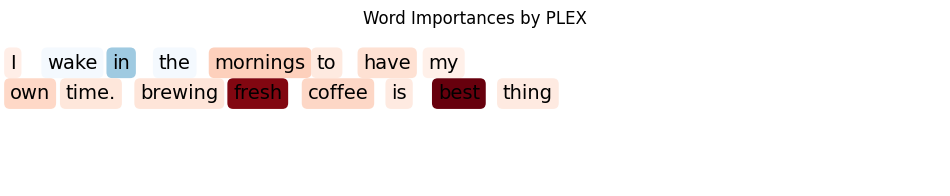

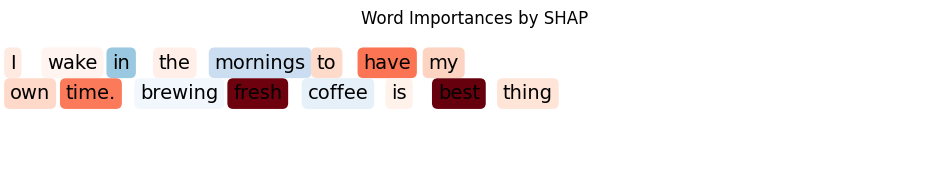

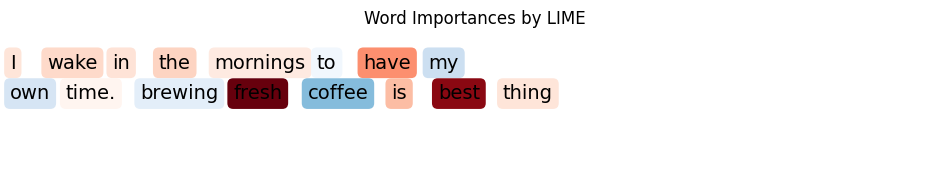

In [60]:
data_point = results[0]
print(f"Sentence: {data_point['sentence']}")
print(f"Predicted Emotion: {data_point['predicted_emotion']}")

# --- Model Importances ---
words = list(data_point['feature_importances_model'].keys())
model_importances = list(data_point['feature_importances_model'].values())

max_abs_importance = max(abs(imp) for imp in model_importances) if model_importances else 1
norm_importances = [imp / max_abs_importance for imp in model_importances]

cmap_neg = plt.get_cmap("Blues")  # Use plt.get_cmap()
cmap_pos = plt.get_cmap("Reds")   # Use plt.get_cmap()

plt.figure(figsize=(12, 2))
x = 0
y = 0.8
word_count = 0
for word, norm_importance in zip(words, norm_importances):
    if norm_importance >= 0:
        color = cmap_pos(norm_importance)
    else:
        color = cmap_neg(-norm_importance) 

    plt.text(x, y, word, fontsize=14, ha='left', va='center', color='black',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x += len(word) * 0.01 + 0.03

    word_count += 1
    if word_count % 8== 0:  # Break into a new row after every 5 words
        x = 0
        y -= 0.2  # Move to the next row

plt.title('Word Importances by PLEX')  # Add title for Model
plt.axis('off')
plt.show()

# --- SHAP Importances ---
words = list(data_point['feature_importances_shap'].keys())
model_importances = list(data_point['feature_importances_shap'].values())

max_abs_importance = max(abs(imp) for imp in model_importances) if model_importances else 1
norm_importances = [imp / max_abs_importance for imp in model_importances]

cmap_neg = plt.get_cmap("Blues")  # Use plt.get_cmap()
cmap_pos = plt.get_cmap("Reds")   # Use plt.get_cmap()

plt.figure(figsize=(12, 2))
x = 0
y = 0.8
word_count = 0
for word, norm_importance in zip(words, norm_importances):
    if norm_importance >= 0:
        color = cmap_pos(norm_importance)
    else:
        color = cmap_neg(-norm_importance) 

    plt.text(x, y, word, fontsize=14, ha='left', va='center', color='black',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x += len(word) * 0.01 + 0.03

    word_count += 1
    if word_count % 8== 0:  # Break into a new row after every 5 words
        x = 0
        y -= 0.2  # Move to the next row

plt.title('Word Importances by SHAP')  # Add title for SHAP
plt.axis('off')
plt.show()

# --- LIME Importances ---
words = list(data_point['feature_importances_lime'].keys())
model_importances = list(data_point['feature_importances_lime'].values())

max_abs_importance = max(abs(imp) for imp in model_importances) if model_importances else 1
norm_importances = [imp / max_abs_importance for imp in model_importances]

cmap_neg = plt.get_cmap("Blues")  # Use plt.get_cmap()
cmap_pos = plt.get_cmap("Reds")   # Use plt.get_cmap()

plt.figure(figsize=(12, 2))
x = 0
y = 0.8
word_count = 0
for word, norm_importance in zip(words, norm_importances):
    if norm_importance >= 0:
        color = cmap_pos(norm_importance)
    else:
        color = cmap_neg(-norm_importance) 

    plt.text(x, y, word, fontsize=14, ha='left', va='center', color='black',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x += len(word) * 0.01 + 0.03

    word_count += 1
    if word_count % 8== 0:  # Break into a new row after every 5 words
        x = 0
        y -= 0.2  # Move to the next row

plt.title('Word Importances by LIME')  # Add title for LIME
plt.axis('off')
plt.show()

# Depression Explanation

In [65]:
text = "My once-bright laughter is now replaced with hollow silence."

In [66]:
class_names = ['depression','happy']
model_name = "poudel/Depression_and_Non-Depression_Classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).to(device)
load_path = 'model_gpt_depression_SHAP_boost.pth'

def load_model(load_path):
    seismic_net.load_state_dict(torch.load(load_path))

def model_importances(cls_embedding,word_embeddings):
    cls_embedding = cls_embedding.to(device)
    feature_importances_model = {}
    for word, word_embedding in word_embeddings.items():
        word_embedding = word_embedding.to(device)
        with torch.no_grad():  # No need to calculate gradients here
            cls_output = seismic_net(cls_embedding).to(device)
            word_output = seismic_net(word_embedding)
            similarity = F.cosine_similarity(cls_output, word_output, dim=0)
            feature_importances_model[word] = similarity.item()
    return feature_importances_model


pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if device.type == "cuda" else -1,
    return_all_scores=True,
)

shap_explainer = shap.Explainer(pred)
lime_explainer = LimeTextExplainer(class_names=class_names)

In [67]:
results=[]
cls_embedding, word_embeddings = word_emb(text)

start_time = time.time()
predicted_emotion_shap, feature_importances_shap = shap_feature_importances(text)
shap_time = time.time() - start_time

# Measure time for LIME
start_time = time.time()
predicted_emotion_lime, feature_importances_lime = lime_feture_importances(text)
lime_time = time.time() - start_time

# Measure time for PLEX
start_time = time.time()
feature_importances_model = model_importances(cls_embedding, word_embeddings)
plex_time = time.time() - start_time

print(f"SHAP time: {shap_time:.4f} seconds")
print(f"LIME time: {lime_time:.4f} seconds")
print(f"PLEX time: {plex_time:.4f} seconds")

results.append({
    "sentence": text,
    "cls_embedding": cls_embedding,
    "word_embeddings": word_embeddings,
    "predicted_emotion": predicted_emotion_shap,
    "feature_importances_shap": feature_importances_shap,
    "feature_importances_lime": feature_importances_lime,
    "feature_importances_model": feature_importances_model
})

data_point = results[0]
model_importances = data_point["feature_importances_model"]
shap_importances = data_point["feature_importances_shap"]
tokenizer = BertTokenizerFast.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
merged_shap_importances = merge_subword_shap_values(model_importances, shap_importances, tokenizer)
data_point["feature_importances_shap"] = merged_shap_importances

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.74s/it]                                                                   


SHAP time: 11.8529 seconds
LIME time: 0.8094 seconds
PLEX time: 0.0165 seconds


Sentence: My once-bright laughter is now replaced with hollow silence.
Predicted Emotion: depression


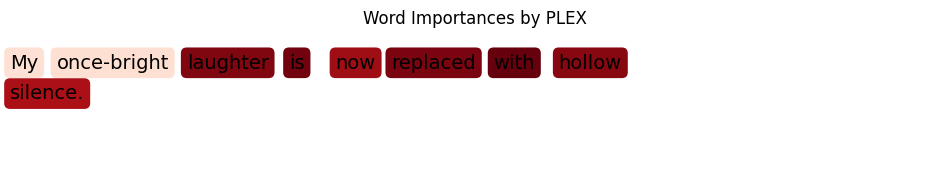

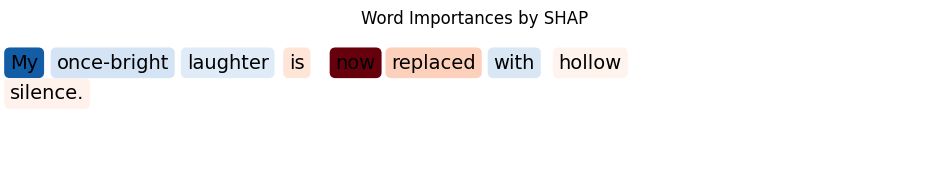

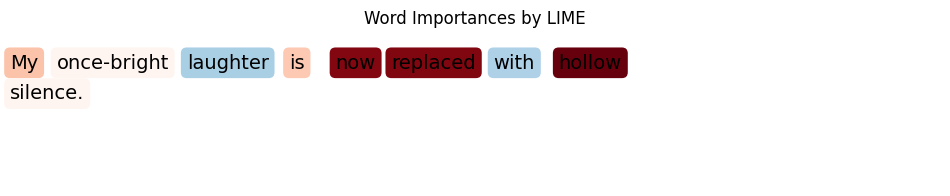

In [68]:
data_point = results[0]
print(f"Sentence: {data_point['sentence']}")
print(f"Predicted Emotion: {data_point['predicted_emotion']}")

# --- Model Importances ---
words = list(data_point['feature_importances_model'].keys())
model_importances = list(data_point['feature_importances_model'].values())

max_abs_importance = max(abs(imp) for imp in model_importances) if model_importances else 1
norm_importances = [imp / max_abs_importance for imp in model_importances]

cmap_neg = plt.get_cmap("Blues")  # Use plt.get_cmap()
cmap_pos = plt.get_cmap("Reds")   # Use plt.get_cmap()

plt.figure(figsize=(12, 2))
x = 0
y = 0.8
word_count = 0
for word, norm_importance in zip(words, norm_importances):
    if norm_importance >= 0:
        color = cmap_pos(norm_importance)
    else:
        color = cmap_neg(-norm_importance) 

    plt.text(x, y, word, fontsize=14, ha='left', va='center', color='black',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x += len(word) * 0.01 + 0.03

    word_count += 1
    if word_count % 8== 0:  # Break into a new row after every 5 words
        x = 0
        y -= 0.2  # Move to the next row

plt.title('Word Importances by PLEX')  # Add title for Model
plt.axis('off')
plt.show()

# --- SHAP Importances ---
words = list(data_point['feature_importances_shap'].keys())
model_importances = list(data_point['feature_importances_shap'].values())

max_abs_importance = max(abs(imp) for imp in model_importances) if model_importances else 1
norm_importances = [imp / max_abs_importance for imp in model_importances]

cmap_neg = plt.get_cmap("Blues")  # Use plt.get_cmap()
cmap_pos = plt.get_cmap("Reds")   # Use plt.get_cmap()

plt.figure(figsize=(12, 2))
x = 0
y = 0.8
word_count = 0
for word, norm_importance in zip(words, norm_importances):
    if norm_importance >= 0:
        color = cmap_pos(norm_importance)
    else:
        color = cmap_neg(-norm_importance) 

    plt.text(x, y, word, fontsize=14, ha='left', va='center', color='black',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x += len(word) * 0.01 + 0.03

    word_count += 1
    if word_count % 8== 0:  # Break into a new row after every 5 words
        x = 0
        y -= 0.2  # Move to the next row

plt.title('Word Importances by SHAP')  # Add title for SHAP
plt.axis('off')
plt.show()

# --- LIME Importances ---
words = list(data_point['feature_importances_lime'].keys())
model_importances = list(data_point['feature_importances_lime'].values())

max_abs_importance = max(abs(imp) for imp in model_importances) if model_importances else 1
norm_importances = [imp / max_abs_importance for imp in model_importances]

cmap_neg = plt.get_cmap("Blues")  # Use plt.get_cmap()
cmap_pos = plt.get_cmap("Reds")   # Use plt.get_cmap()

plt.figure(figsize=(12, 2))
x = 0
y = 0.8
word_count = 0
for word, norm_importance in zip(words, norm_importances):
    if norm_importance >= 0:
        color = cmap_pos(norm_importance)
    else:
        color = cmap_neg(-norm_importance) 

    plt.text(x, y, word, fontsize=14, ha='left', va='center', color='black',
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.3'))
    x += len(word) * 0.01 + 0.03

    word_count += 1
    if word_count % 8== 0:  # Break into a new row after every 5 words
        x = 0
        y -= 0.2  # Move to the next row

plt.title('Word Importances by LIME')  # Add title for LIME
plt.axis('off')
plt.show()